# Creating a Multigrid Poisson Solver
Multigrid solvers are built on a few key observations:
  * Iterative solvers, like the Jacobi solver, correct the small scale errors of a solution faster than the large scale errors
  * The solution to the Poisson equation can be used to formulate an analogous equation for the solution of the error term
  * By using a __restriction operator__ we can solve the equation for the error term on a coarse mesh
  * By using a __prolongation operator__ we can propogate the solution for the error term from the coarse to the fine mesh
  * This can be done recursively
  * Solving on the coarse mesh is cheaper by a factor 2^ndim

In this exercise you will get the chance to build a nice recursive piece of code by yourself and create a multigrid solver. Below are only given the logical pieces, the rest you have to create.

_This exercise counts for the full week_

## Preparation:
At the bottom write a section heading, "Solution", and copy the multigrid class and the small piece of to run the solver below it. This gives you a clean reference code above, and makes it easier to see what has been modified.

#### Task 1 (40 pt):  
Create the prolongation and restriction operators, and the central recursive algorithm (see the code below).

#### Task 2 (40 pt):
Validate the solver. Multigrid solvers have the central property that, for a given tolerance, the number of needed multigrid cycles only depends weakly on the resolution
Compare with a simple Jacobi integrator. Notice the ```maxit```option that may have to be increased for it to converge, if you go to high resolutions.

#### Task 3 (20 pt):
Timing: at what resolution does your multigrid solver become faster than the Jacobi solver?

#### Extra open task  (up to 20 pt):
The convergence properties of a multi grid solver can be be improved by not doing the full cycle up and down (V-cycle), but instead first going all the way down, then half way up, down again, and then all the way up (W-cycle). Change the solver to a W-cycle, or explore other cycle configurations (see e.g. the link at the end of the slides). 

In [213]:
import numpy as np
import matplotlib.pyplot as plt
import images as im
from time import time
np.set_printoptions(linewidth=120)
import scipy as sc
import pylab

### Hydro data class and initial conditions

In [2]:
class HD():
    def __init__(u,n=(32,32,32),nv=1,gamma=1.4,cs=1.,G=1.,L=2.0,d0=1.):
        # make n a 3-tuple if given as an integer
        if isinstance(n, int):
            m = (n,n,n)
        else:
            m = n
        u.n = m                             # resolution of the grid is (n[1],n[2],n[3])
        u.it= 0                             # number of updates (integer)
        u.t = 0.0                           # Time
        u.nv = nv                           # number of variables. We use nv = 8 = (density, total energy, momentum[xyz], magnetic field[xyz])
        u.ndim = 3                          # dimensionality of the experiment
        u.G     = G                         # Newtons constant of gravity
        u.var   = np.zeros((nv,)+m)         # conserved variables. "(nv,)+m gives a 4-tuple with (nv,n[0],n[1],n[2])"
        u.D     = u.var[0]                  # mass density pointer
        u.D[:,:,:] = d0                     # constand density
        u.coordinates(n=m,L=L)              # define coordinate system
        u.varnames=np.array(('D'))
        
    def coordinates(u,n,L=2.0):             # function to define coordinates
        # make cell centered coordinates with domain boundaries [-L:L]^ndim
        u.ds = L / n[0]                     # cell size
        LL = 0.5*u.ds*n[0], 0.5*u.ds*n[1], 0.5*u.ds*n[2]
        u.x = np.linspace(-LL[0],LL[0],n[0], endpoint=False) + 0.5 * u.ds # cell centered coordinates
        u.y = np.linspace(-LL[1],LL[1],n[1], endpoint=False) + 0.5 * u.ds
        u.z = np.linspace(-LL[2],LL[2],n[2], endpoint=False) + 0.5 * u.ds
        u.coords = np.array(np.meshgrid(u.x,u.y,u.z,indexing='ij')) # expand to 3D grid
        u.r = np.sqrt(np.sum(u.coords[0:3]**2,axis=0)) # spherical radius
        u.L = 2.*np.array(LL)               # box size
        u.n = n                             # number of grid points

def BonnorEbert(n=32,r0=0.5,rc=0.1):
    """ Simple 1/(r+rc)^2 for r < r0 density distribution """
    u=HD(n=n)
    u.D[:,:,:] = 0.
    ii = np.where(u.r <= r0)
    u.D[ii] = 1. / (u.r[ii]+rc)**2
    return u

### Jacobi solver and computation of residual

In [3]:
def Jacobi_residual(Phi,S):
    """ calculate explicit residual for given Phi, S """
    n = Phi.shape        # grid size
    res = np.copy(S)
    for i in range(3):
        if n[i] > 1:
            res += (np.roll(Phi,+1,axis=i)+np.roll(Phi,-1,axis=i)) - 2.*Phi
    # fix boundaries
    if n[0] > 2:
        res[0,:,:] = res[-1,:,:] = 0.
    if n[1] > 2:
        res[:,0,:] = res[:,-1,:] = 0.
    if n[2] > 2:
        res[:,:,0] = res[:,:,-1] = 0.
    return res

def Jacobi(Phi,S):
    """ Jacobi iteration for multi-grid self-gravity """
    n = Phi.shape  # grid size

    const = 0.     # Prefactor for normalising dimensions (2 * ndim)
    #   phi = 1/(2ndim) (phi(i-1,j,k)+phi(i+1,j,k)+... - 4 pi G ds^2 rho)
    #   Pad Phi with zeros in each direction for boundary values (assumed to be zero) using numpy.pad
    Phi_new = np.copy(S)   # copy source
    if n[0] > 1:
        const += 2.
        PP = np.pad(Phi, ((1,1),(0,0),(0,0)), 'constant', constant_values=(0., 0.))
        Phi_new += (np.roll(PP,+1,axis=0)+np.roll(PP,-1,axis=0))[1:-1,:,:]
    if n[1] > 1:
        const += 2.
        PP = np.pad(Phi, ((0,0),(1,1),(0,0)), 'constant', constant_values=(0., 0.))
        Phi_new += (np.roll(PP,+1,axis=1)+np.roll(PP,-1,axis=1))[:,1:-1,:]
    if n[2] > 1:
        const += 2.
        PP = np.pad(Phi, ((0,0),(0,0),(1,1)), 'constant', constant_values=(0., 0.))
        Phi_new += (np.roll(PP,+1,axis=2)+np.roll(PP,-1,axis=2))[:,:,1:-1]

    Phi_new *= (1./const) # normalise

    # Return solution and residual (Phi_new - Phi = S + Laplace Phi)
    return Phi_new, Phi_new - Phi

### Iterative Jacobi solver for selfgravity

In [4]:
class poisson():
    def __init__(self, u, tolerance=1e-4,maxit=2000):
        """ Initialize a Poisson solver """
        self.n         = u.n       # Mesh size
        self.maxit     = maxit     # Maximum number of iterative steps to take
        self.tolerance = tolerance # Tolerance to satisfy for the error

    # Iterative Solver for the Poisson Problem
    def Poisson(self,u):
        S = -(4.*np.pi*u.G)*u.D*u.ds**2
        norm   = np.amax(np.abs(S))
        Phi = np.zeros(self.n)        # Start guess =0
        self.it = 0; self.error = self.tolerance
        while self.error >= self.tolerance and self.it<self.maxit:
            Phi, residual = Jacobi(Phi,S)
            self.error = np.amax(np.abs(residual) / norm)
            self.it+=1
            
        residual = Jacobi_residual(Phi,S)
                    
        return Phi, self.it, self.error, residual

### Driver for calling the Jacobi solver

Nr of iterations, error, tolerance : 992 9.98e-05 1.0e-04
Time = 0.9 seconds, 27.7 musec/cell, 27.9 nanosec/cell/it


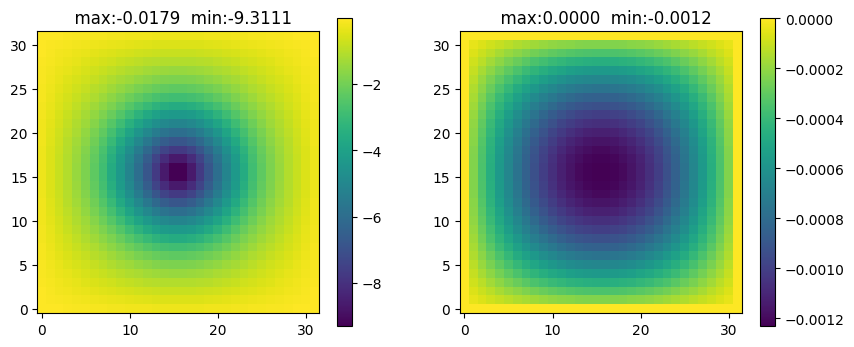

In [5]:
u = BonnorEbert(n=32,rc=0.1, r0=0.5)
P = poisson(u,maxit=4000)

start = time()
Phi, nt, err, res = P.Poisson(u)
used = time() - start
ntot = u.n[0]*u.n[1]*u.n[2]
print("Nr of iterations, error, tolerance : {} {:.2e} {:.1e}".format(nt, err, P.tolerance))
print("Time = {:.1f} seconds, {:.1f} musec/cell, {:.1f} nanosec/cell/it".format(used,1e6*used/ntot,1e9*used/(ntot*nt)))

# Show solution, Phi, and residual, res, side-by-side
im.imshows(np.array( [Phi[:,:,u.n[2]//2],res[:,:,u.n[2]//2]]))

### Investigating the solution

Plot the size of the potential, $\Phi$, as a function of distance from center $r$. Notice how it strays from a perfect spherical solution because we restrict it to be zero on the boundary

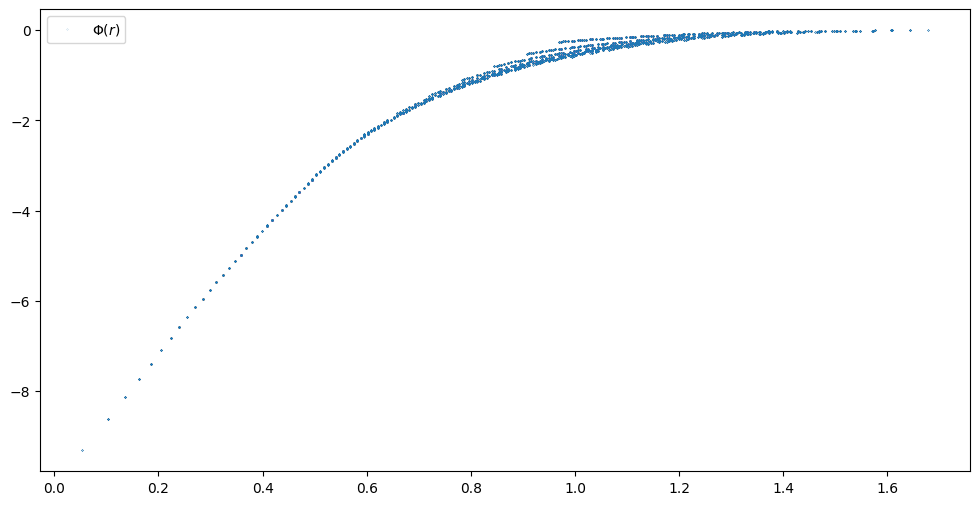

In [6]:
f = plt.figure(figsize=(12,6))
plt.plot(u.r.ravel(),Phi.ravel(),'o',markersize=0.1,label=r'$\Phi(r)$')
plt.legend();

### Multigrid Solver

Make a Multigrid solver class / object, which given a hydro object finds the solution for the potential

In [283]:
class Multigrid():
    def __init__(self,u,tolerance=1e-5,maxit=200,itsmooth=1):
        """ initialize Poisson solver class for u """
        self.itsmooth = itsmooth    # How many Jacobi iteration to take on each level
        self.maxit = maxit          # maximum number multigrid iterations. Depends on tolerance
        self.tolerance = tolerance  # tolerance to satisfy for the error
        self.setup_grids(u.n)       # generate hierarchy of grids for multigrid cycle
        self.setup_residuals(u.n)
        
    def setup_grids(self,n):
        """ setup the dimensions and allocate storage for solutions on multigrid meshes """
        nn = np.array(n)                   # convert dimensions to numpy array
        nm = [];  nm.append(np.copy(nn))   # store dimension of level
        Phi = []; Phi.append(np.zeros(nn)) # array to store solution for this level
        print("MG level, n:",0, nn) # Info
        while np.any(nn % 2 == 0):         # check if any dimension still is divisible by 2
            if np.all(nn <= 2):            # reached 2x2x2 problem, stop
                break
            ii = np.where(nn % 2 == 0) # check which dimensions we can reduce
            nn[ii] = nn[ii] / 2        # reduce
            nm.append(np.copy(nn))     # store in level structure
            Phi.append(np.zeros(nn))   # array to store solution at this level
            print ("MG level, n:", len(nm)-1, nn) # info
        # Store data structure in class
        self.level = len(nm)-1         # max level (zero-indexed)
        self.n     = nm                # mesh sizes
        self.Phi   = Phi               # current solution on each level

    def setup_residuals(self,n):
        """ setup the dimensions and allocate storage for solutions on multigrid meshes """
        nn = np.array(n)                   # convert dimensions to numpy array
        nm = [];  nm.append(np.copy(nn))   # store dimension of level
        res = []; res.append(np.zeros(nn)) # array to store solution for this level
        while np.any(nn % 2 == 0):         # check if any dimension still is divisible by 2
            if np.all(nn <= 2):            # reached 2x2x2 problem, stop
                break
            ii = np.where(nn % 2 == 0) # check which dimensions we can reduce
            nn[ii] = nn[ii] / 2        # reduce
            nm.append(np.copy(nn))     # store in level structure
            res.append(np.zeros(nn))   # array to store solution at this level
        # Store data structure in class
        self.level = len(nm)-1         # max level (zero-indexed)
        self.n     = nm                # mesh sizes
        self.res   = res               # current solution on each level
        
    def restrict(self,f_fine):
        """ restrict residual to coarser level by taking every second element """
        n = np.array(np.shape(f_fine))
        lv=2
        f_coarse=f_fine[::lv,::lv,::lv].copy() 
        return f_coarse
    
    
    
    def one_layer_initial(self,x_fine): ### function used for the prolongation
        wr = x_fine.copy()
        wr[::2, 1:-2:2] = (wr[::2, :-2:2] + wr[::2, 2::2]) / 2
        wr[:,-1] = (wr[:,0] + wr[:,-2]) / 2
        wr[1:-2:2] = (wr[:-2:2] + wr[2::2]) / 2
        wr[-1] = (wr[0] + wr[-2]) / 2
        return wr.copy()
    
    def prolong(self, x_coarse,level): ###prolongation function
        n_coarse = np.array(np.shape(x_coarse))
        x_fine = np.zeros(n_coarse * 2)
        n_fine = int(n_coarse[0] * 2)
        x_fine[::2, ::2, ::2] = x_coarse.copy()

        for i in range(0, n_fine, 2):
            x_fine[i] = self.one_layer_initial(x_fine[i])

        x_fine[1:-2:2] = np.copy((x_fine[:-2:2] + x_fine[2::2]) / 2)
        x_fine[-1] = np.copy((x_fine[0] + x_fine[-2]) / 2)

        return x_fine
    
    
    def solver(self,S,Phi):
        """ do itsmooth Jacobi iterations """
        for i in range(self.itsmooth):
            Phi[:,:,:], _ = Jacobi(Phi,S)
        residual = Jacobi_residual(Phi,S)
        return residual
    

    def MGcycle(self,level,source):
        residual = self.solver(source, self.Phi[level])                  # iterate solution at this level
        
        ### Going all the way down ###
        while level < self.level:                               # if not on coarsest level, recurse
            # 1. restrict residual from current level to coarse level (=level+1)
            level += 1
            self.res[level] = self.restrict(residual)
      
            # 2. call solve at coarser level (e.g. level+1) 
            residual = self.solver(self.res[level], self.Phi[level])
        
        ### Going all the way up ###   
        while level > 0:
            # 3. prolong the solution for Phi from the coarser level (=level+1) and add to solution on this level
            e = self.prolong(self.Phi[level],level)
        
            level -= 1
            self.Phi[level] += e

            if level != 0:
                self.solver(self.res[level], self.Phi[level])  #we solve at each prolongated level     
          
        self.solver(source,self.Phi[level])                 # iterate solution again at this level
        
    def full_solve(self,u):
        S = -(4.*np.pi*u.G)*u.D*u.ds**2
        norm   = np.amax(np.abs(S))                  # normalisation for residual
        self.it = 0
        self.error = self.tolerance
        # Main loop
        er=[] #list that it could be used for plotting the error.
        while self.error >= self.tolerance and self.it<self.maxit:
            self.MGcycle(0,S)                        # do a full multigrid cycle
            self.it += 1                             # inc nr of MG iterations
            res = Jacobi_residual(self.Phi[0],S)     # compute residual
            self.error = np.amax(np.abs(res) / norm) # estimate error
        return self.Phi[0], res, er

#### Test of the multigrid class 

MG level, n: 0 [32 32 32]
MG level, n: 1 [16 16 16]
MG level, n: 2 [8 8 8]
MG level, n: 3 [4 4 4]
MG level, n: 4 [2 2 2]
Nr of iterations, error, tolerance : 22 9.85e-04 1.0e-03
Time = 0.4 seconds, 12.2 musec/cell, 12.3 nanosec/cell/it


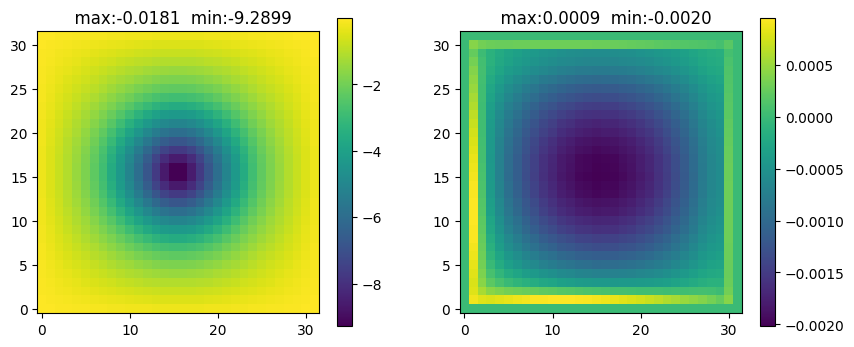

In [329]:
n=32
u = BonnorEbert(n=n,rc=0.1, r0=0.5)                    # Compute the density distribution
M = Multigrid(u,maxit=1000,itsmooth=3,tolerance=1e-3)  # Setup the Multigrid solver object

start = time()              # for timing
Phi, res, er = M.full_solve(u)  # call the multigrid solver
used = time() - start       # for timing

# print some statistics
ntot = u.n[0]*u.n[1]*u.n[2]
print("Nr of iterations, error, tolerance : {} {:.2e} {:.1e}".format(M.it, M.error, M.tolerance))
print("Time = {:.1f} seconds, {:.1f} musec/cell, {:.1f} nanosec/cell/it".format(
    used,1e6*used/ntot,1e9*used/(ntot*nt)))

# show potetial and residual
im.imshows(np.array([Phi[:,:,u.n[2]//2],res[:,:,u.n[2]//2]]))

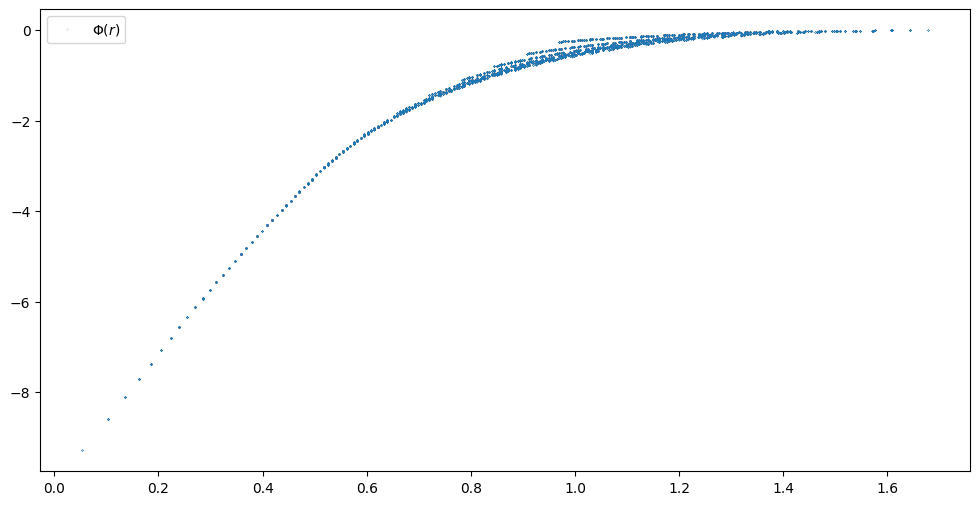

In [265]:
f = plt.figure(figsize=(12,6))
plt.plot(u.r.ravel(),Phi.ravel(),'o',markersize=0.1,label=r'$\Phi(r)$')
plt.legend();

----
#### Add your solution below

### ${\bf Task\ 1}$

The functions are present in the class Multigrid. There are some comments. I will add them below!

In [326]:
def restrict(self,f_fine):   ###RESTRICTION
        """ restrict residual to coarser level by taking every second element """
        n = np.array(np.shape(f_fine))
        lv=2
        f_coarse=f_fine[::lv,::lv,::lv].copy() 
        return f_coarse
    
def one_layer_initial(self,x_fine): ### FUNCTION BEING USED FOR THE PROLONGATION
        wr = x_fine.copy()
        wr[::2, 1:-2:2] = (wr[::2, :-2:2] + wr[::2, 2::2]) / 2
        wr[:,-1] = (wr[:,0] + wr[:,-2]) / 2
        wr[1:-2:2] = (wr[:-2:2] + wr[2::2]) / 2
        wr[-1] = (wr[0] + wr[-2]) / 2
        return wr.copy()
    
def prolong(self, x_coarse,level): ###PROLONGATION
        n_coarse = np.array(np.shape(x_coarse))
        x_fine = np.zeros(n_coarse * 2)
        n_fine = int(n_coarse[0] * 2)
        x_fine[::2, ::2, ::2] = x_coarse.copy()

        for i in range(0, n_fine, 2):
            x_fine[i] = self.one_layer_initial(x_fine[i])

        x_fine[1:-2:2] = np.copy((x_fine[:-2:2] + x_fine[2::2]) / 2)
        x_fine[-1] = np.copy((x_fine[0] + x_fine[-2]) / 2)

        return x_fine
    
def MGcycle(self,level,source):
        residual = self.solver(source, self.Phi[level])                  # iterate solution at this level
        
        ### Going all the way down ###
        while level < self.level:                               # if not on coarsest level, recurse
            # 1. restrict residual from current level to coarse level (=level+1)
            level += 1
            self.res[level] = self.restrict(residual)
      
            # 2. call solve at coarser level (e.g. level+1) 
            residual = self.solver(self.res[level], self.Phi[level])
        
        ### Going all the way up ###   
        while level > 0:
            # 3. prolong the solution for Phi from the coarser level (=level+1) and add to solution on this level
            e = self.prolong(self.Phi[level],level)
        
            level -= 1
            self.Phi[level] += e

            if level != 0:
                self.solver(self.res[level], self.Phi[level])       
          
        self.solver(source,self.Phi[level])  

### ${\bf Task\ 2}$

We have chosen some specific values fo the multigrid method V-Cycle. Particularly, we set $itsmooth\ =\ 3$ and $tolerance\ = 10^{-3}$. We compared these two methods for $n=32$. Our main focus would be the iterations that are used in each case.

MG level, n: 0 [32 32 32]
MG level, n: 1 [16 16 16]
MG level, n: 2 [8 8 8]
MG level, n: 3 [4 4 4]
MG level, n: 4 [2 2 2]
Nr of iterations, error, tolerance : 22 9.85e-04 1.0e-03
Time = 0.4 seconds, 12.3 musec/cell, 12.4 nanosec/cell/it


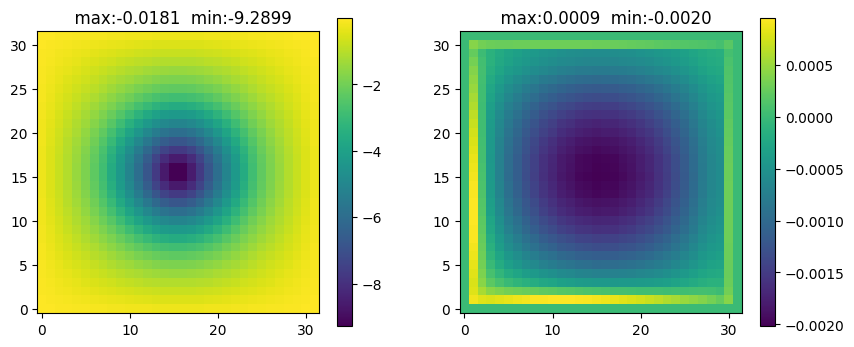

In [328]:
n=32
u = BonnorEbert(n=n,rc=0.1, r0=0.5)                    # Compute the density distribution
M = Multigrid(u,maxit=1000,itsmooth=3,tolerance=1e-3)  # Setup the Multigrid solver object

start = time()              # for timing
Phi, res, er = M.full_solve(u)  # call the multigrid solver
used = time() - start       # for timing

# print some statistics
ntot = u.n[0]*u.n[1]*u.n[2]
print("Nr of iterations, error, tolerance : {} {:.2e} {:.1e}".format(M.it, M.error, M.tolerance))
print("Time = {:.1f} seconds, {:.1f} musec/cell, {:.1f} nanosec/cell/it".format(
    used,1e6*used/ntot,1e9*used/(ntot*nt)))

# show potetial and residual
im.imshows(np.array([Phi[:,:,u.n[2]//2],res[:,:,u.n[2]//2]]))

Nr of iterations, error, tolerance : 992 9.98e-05 1.0e-04
Time = 0.9 seconds, 26.5 musec/cell, 26.7 nanosec/cell/it


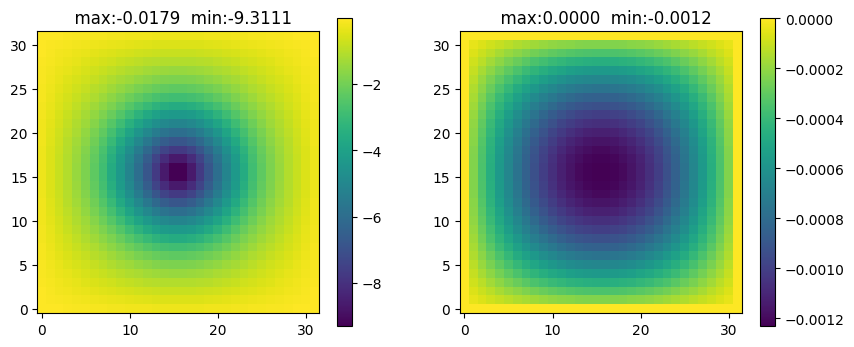

In [325]:
u = BonnorEbert(n=32,rc=0.1, r0=0.5)
P = poisson(u,maxit=4000)

start = time()
Phi, nt, err, res = P.Poisson(u)
used = time() - start
ntot = u.n[0]*u.n[1]*u.n[2]
print("Nr of iterations, error, tolerance : {} {:.2e} {:.1e}".format(nt, err, P.tolerance))
print("Time = {:.1f} seconds, {:.1f} musec/cell, {:.1f} nanosec/cell/it".format(used,1e6*used/ntot,1e9*used/(ntot*nt)))


# Show solution, Phi, and residual, res, side-by-side
im.imshows(np.array( [Phi[:,:,u.n[2]//2],res[:,:,u.n[2]//2]]))

Obviously, the number of iterations being used in the case of the multigrid method (22 iterations) are far less than the ones of the simple Jacobian one (992 iterations). Thus, the multigrid method is using less iterations in order to reach the solution.

Now, it is needed to validate our multigrid method by realising that the number of the iterations depends weakly on the resolution. Of course we do not expect to use the exact iterations, but the difference of those should be small. Again we could compare the two above ways for $n=32$ and $n=64$ and show that the difference in the number of iterations used by the simple Jacobian between these two case, is bigger than the one of the multigrid.

MG level, n: 0 [64 64 64]
MG level, n: 1 [32 32 32]
MG level, n: 2 [16 16 16]
MG level, n: 3 [8 8 8]
MG level, n: 4 [4 4 4]
MG level, n: 5 [2 2 2]
Nr of iterations, error, tolerance : 83 8.57e-04 1.0e-03
Time = 7.7 seconds, 29.5 musec/cell, 29.7 nanosec/cell/it


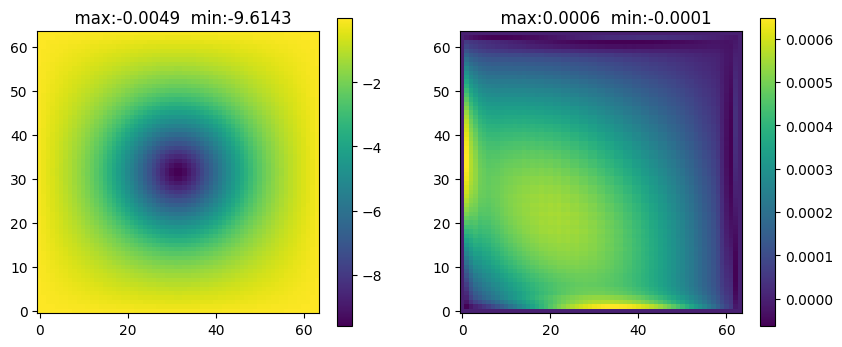

In [332]:
n=64
u = BonnorEbert(n=n,rc=0.1, r0=0.5)                    # Compute the density distribution
M = Multigrid(u,maxit=1000,itsmooth=3,tolerance=1e-3)  # Setup the Multigrid solver object

start = time()              # for timing
Phi, res, er = M.full_solve(u)  # call the multigrid solver
used = time() - start       # for timing

# print some statistics
ntot = u.n[0]*u.n[1]*u.n[2]
print("Nr of iterations, error, tolerance : {} {:.2e} {:.1e}".format(M.it, M.error, M.tolerance))
print("Time = {:.1f} seconds, {:.1f} musec/cell, {:.1f} nanosec/cell/it".format(
    used,1e6*used/ntot,1e9*used/(ntot*nt)))

# show potetial and residual
im.imshows(np.array([Phi[:,:,u.n[2]//2],res[:,:,u.n[2]//2]]))

Nr of iterations, error, tolerance : 3554 9.99e-05 1.0e-04
Time = 33.4 seconds, 127.5 musec/cell, 35.9 nanosec/cell/it


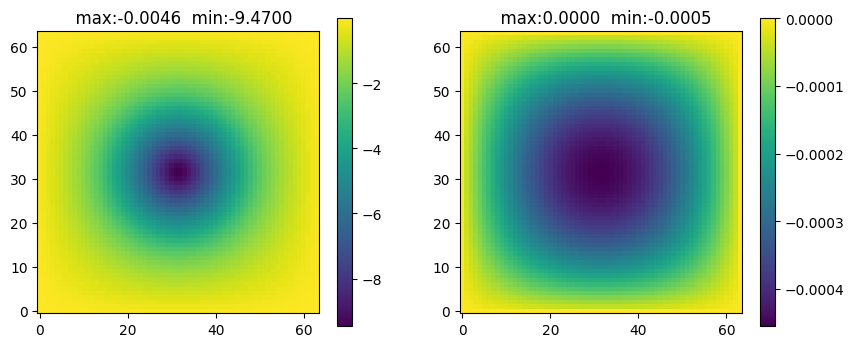

In [168]:
u = BonnorEbert(n=64,rc=0.1, r0=0.5)
P = poisson(u,maxit=4000)

start = time()
Phi, nt, err, res = P.Poisson(u)
used = time() - start
ntot = u.n[0]*u.n[1]*u.n[2]
print("Nr of iterations, error, tolerance : {} {:.2e} {:.1e}".format(nt, err, P.tolerance))
print("Time = {:.1f} seconds, {:.1f} musec/cell, {:.1f} nanosec/cell/it".format(used,1e6*used/ntot,1e9*used/(ntot*nt)))

# Show solution, Phi, and residual, res, side-by-side
im.imshows(np.array( [Phi[:,:,u.n[2]//2],res[:,:,u.n[2]//2]]))

For the case of multigrid function, we doubled the resolution of the grid and the extra iterations that have been used are rougly 60, while in the case of the of the simple Jacobian method are more than 1000. Consequently, a change in the resolution of the system-grid affects significantly that number of iterations used by the Jacobian, while this does not occur for the multigrid as the change is small (weak dependence).

### ${\bf Task\ 3}$

On this task, we are going to focus on the speed of the above two methods. Below we are plotting the time that is used by each method to finish for different resolutions. We have chosen $resolution= 2^{2}, 2^{3}, 2^{4}, 2^{5}, 2^{6}$

In [227]:
mt=[]
jt=[]

for i in range(2,7,1):
    n=i
    u = BonnorEbert(n=2**i,rc=0.1, r0=0.5)                    # Compute the density distribution
    M = Multigrid(u,maxit=1000,itsmooth=3,tolerance=1e-3)  # Setup the Multigrid solver object

    start = time()              # for timing
    Phi, res, er = M.full_solve(u)  # call the multigrid solver
    used = time() - start       # for timing
    ntot = u.n[0]*u.n[1]*u.n[2]
    #print("Time = {:.1f} seconds, {:.1f} musec/cell, {:.1f} nanosec/cell/it".format(
    #used,1e6*used/ntot,1e9*used/(ntot*nt)))
    #print('\n')
    mt.append(used) 

for i in range(2,7,1):
    u = BonnorEbert(n=2**i,rc=0.1, r0=0.5)
    P = poisson(u,maxit=4000)
    start = time()
    Phi, nt, err, res = P.Poisson(u)
    used = time() - start
    ntot = u.n[0]*u.n[1]*u.n[2]
    #print(i)
    #print("Time = {:.1f} seconds, {:.1f} musec/cell, {:.1f} nanosec/cell/it".format(used,1e6*used/ntot,1e9*used/(ntot*nt)))
    #print('\n')

    jt.append(used)

MG level, n: 0 [4 4 4]
MG level, n: 1 [2 2 2]
MG level, n: 0 [8 8 8]
MG level, n: 1 [4 4 4]
MG level, n: 2 [2 2 2]
MG level, n: 0 [16 16 16]
MG level, n: 1 [8 8 8]
MG level, n: 2 [4 4 4]
MG level, n: 3 [2 2 2]
MG level, n: 0 [32 32 32]
MG level, n: 1 [16 16 16]
MG level, n: 2 [8 8 8]
MG level, n: 3 [4 4 4]
MG level, n: 4 [2 2 2]
MG level, n: 0 [64 64 64]
MG level, n: 1 [32 32 32]
MG level, n: 2 [16 16 16]
MG level, n: 3 [8 8 8]
MG level, n: 4 [4 4 4]
MG level, n: 5 [2 2 2]


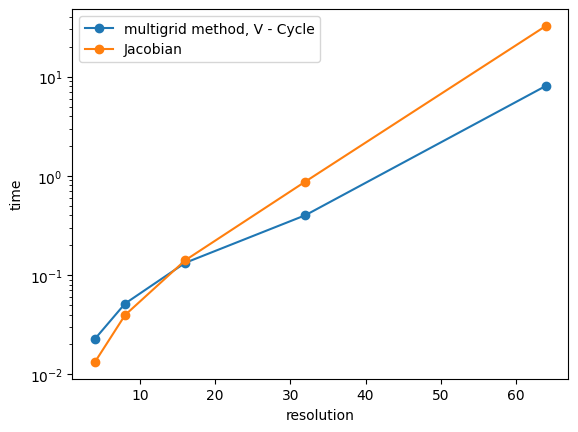

In [270]:
n=[2**i for i in range(2,7)]
plt.yscale("log")
plt.plot(n,mt,label='multigrid method, V - Cycle',marker='o')
plt.plot(n,jt,label='Jacobian',marker='o')
plt.xlabel('resolution')
plt.ylabel('time')
plt.legend()

According to the plot above, for $n\geq2^{4}$, where n is the resolution of the grid, the multigrid method V-Cycle is faster than the Jacobian

### ${\bf Bonus\ Task}$

We are going to investigate the W-cycle. Below we are going to define a new class for the W-cycle, where the code of the cycle is present

In [311]:
class MultigridW():
    def __init__(self,u,tolerance=1e-5,maxit=200,itsmooth=1):
        """ initialize Poisson solver class for u """
        self.itsmooth = itsmooth    # How many Jacobi iteration to take on each level
        self.maxit = maxit          # maximum number multigrid iterations. Depends on tolerance
        self.tolerance = tolerance  # tolerance to satisfy for the error
        self.setup_grids(u.n)       # generate hierarchy of grids for multigrid cycle
        self.setup_residuals(u.n)
        
    def setup_grids(self,n):
        """ setup the dimensions and allocate storage for solutions on multigrid meshes """
        nn = np.array(n)                   # convert dimensions to numpy array
        nm = [];  nm.append(np.copy(nn))   # store dimension of level
        Phi = []; Phi.append(np.zeros(nn)) # array to store solution for this level
        print("MG level, n:",0, nn) # Info
        while np.any(nn % 2 == 0):         # check if any dimension still is divisible by 2
            if np.all(nn <= 2):            # reached 2x2x2 problem, stop
                break
            ii = np.where(nn % 2 == 0) # check which dimensions we can reduce
            nn[ii] = nn[ii] / 2        # reduce
            nm.append(np.copy(nn))     # store in level structure
            Phi.append(np.zeros(nn))   # array to store solution at this level
            print ("MG level, n:", len(nm)-1, nn) # info
        # Store data structure in class
        self.level = len(nm)-1         # max level (zero-indexed)
        self.n     = nm                # mesh sizes
        self.Phi   = Phi               # current solution on each level

    def setup_residuals(self,n):
        """ setup the dimensions and allocate storage for solutions on multigrid meshes """
        nn = np.array(n)                   # convert dimensions to numpy array
        nm = [];  nm.append(np.copy(nn))   # store dimension of level
        res = []; res.append(np.zeros(nn)) # array to store solution for this level
        while np.any(nn % 2 == 0):         # check if any dimension still is divisible by 2
            if np.all(nn <= 2):            # reached 2x2x2 problem, stop
                break
            ii = np.where(nn % 2 == 0) # check which dimensions we can reduce
            nn[ii] = nn[ii] / 2        # reduce
            nm.append(np.copy(nn))     # store in level structure
            res.append(np.zeros(nn))   # array to store solution at this level
        # Store data structure in class
        self.level = len(nm)-1         # max level (zero-indexed)
        self.n     = nm                # mesh sizes
        self.res   = res               # current solution on each level
        
    def restrict(self,f_fine):
        """ restrict residual to coarser level by taking every second element """
        n = np.array(np.shape(f_fine))
        lv=2
        f_coarse=f_fine[::lv,::lv,::lv].copy() 
        return f_coarse
    
    def one_layer_initial(self,x_fine): ### function used for the prolongation
        wr = x_fine.copy()
        wr[::2, 1:-2:2] = (wr[::2, :-2:2] + wr[::2, 2::2]) / 2
        wr[:,-1] = (wr[:,0] + wr[:,-2]) / 2
        wr[1:-2:2] = (wr[:-2:2] + wr[2::2]) / 2
        wr[-1] = (wr[0] + wr[-2]) / 2
        return wr.copy()
    
    def prolong(self, x_coarse,level):
        n_coarse = np.array(np.shape(x_coarse))
        x_fine = np.zeros(n_coarse * 2)
        n_fine = int(n_coarse[0] * 2)
        x_fine[::2, ::2, ::2] = x_coarse.copy()

        for i in range(0, n_fine, 2):
            x_fine[i] = self.one_layer_initial(x_fine[i])

        x_fine[1:-2:2] = np.copy((x_fine[:-2:2] + x_fine[2::2]) / 2)
        x_fine[-1] = np.copy((x_fine[0] + x_fine[-2]) / 2)

        return x_fine
    
    
    def solver(self,S,Phi):
        """ do itsmooth Jacobi iterations """
        for i in range(self.itsmooth):
            Phi[:,:,:], _ = Jacobi(Phi,S)
        residual = Jacobi_residual(Phi,S)
        return residual

    def MGcycle(self,level,source): ###FOR W CYCLE###
        residual = self.solver(source, self.Phi[level])                 
        
        ### Going all the way down ###
        while level < self.level:                               
            level += 1
            self.res[level] = self.restrict(residual)
            residual = self.solver(self.res[level], self.Phi[level])
        
        ### Going half the way up ###   
        while level > int(self.level/2):
            e = self.prolong(self.Phi[level],level)
            level -= 1
            self.Phi[level] += e
            if level != 0:
                residual=self.solver(self.res[level], self.Phi[level]) #we must have the residual of the half way in order to restrict it again after the loop ends!!
        
        ###Going all the way down  ###     
        while level < self.level:                               
            level += 1
            self.res[level] = self.restrict(residual) 
            residual = self.solver(self.res[level], self.Phi[level]) 
        ### Going up ###   
        while level > 0:
            e = self.prolong(self.Phi[level],level)
        
            level -= 1
            self.Phi[level] += e

            if level != 0:
                self.solver(self.res[level], self.Phi[level])       
          
        self.solver(source,self.Phi[level]) #solve at the top of the cycle               
        
    def full_solve(self,u):
        S = -(4.*np.pi*u.G)*u.D*u.ds**2
        norm   = np.amax(np.abs(S))                  # normalisation for residual
        self.it = 0
        self.error = self.tolerance
        # Main loop
        er=[] #list that it could be used for plotting the error.
        while self.error >= self.tolerance and self.it<self.maxit:
            self.MGcycle(0,S)                        # do a full multigrid cycle
            self.it += 1                             # inc nr of MG iterations
            res = Jacobi_residual(self.Phi[0],S)     # compute residual
            self.error = np.amax(np.abs(res) / norm) # estimate error
        return self.Phi[0], res, er

MG level, n: 0 [16 16 16]
MG level, n: 1 [8 8 8]
MG level, n: 2 [4 4 4]
MG level, n: 3 [2 2 2]
Nr of iterations, error, tolerance : 11 5.60e-04 1.0e-03
Time = 0.2 seconds, 44.3 musec/cell, 44.6 nanosec/cell/it


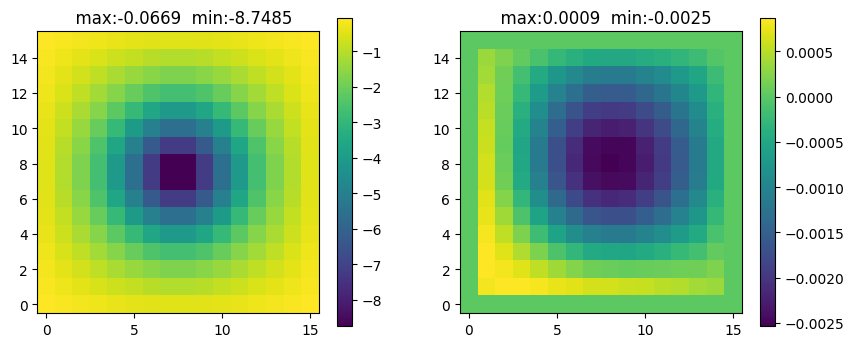

In [303]:
n=16
u = BonnorEbert(n=n,rc=0.1, r0=0.5)                    # Compute the density distribution
M = MultigridW(u,maxit=1000,itsmooth=3,tolerance=1e-3)  # Setup the Multigrid solver object

start = time()              # for timing
Phi, res, er = M.full_solve(u)  # call the multigrid solver
used = time() - start       # for timing

# print some statistics
ntot = u.n[0]*u.n[1]*u.n[2]
print("Nr of iterations, error, tolerance : {} {:.2e} {:.1e}".format(M.it, M.error, M.tolerance))
print("Time = {:.1f} seconds, {:.1f} musec/cell, {:.1f} nanosec/cell/it".format(
    used,1e6*used/ntot,1e9*used/(ntot*nt)))

# show potetial and residual
im.imshows(np.array([Phi[:,:,u.n[2]//2],res[:,:,u.n[2]//2]]))

MG level, n: 0 [32 32 32]
MG level, n: 1 [16 16 16]
MG level, n: 2 [8 8 8]
MG level, n: 3 [4 4 4]
MG level, n: 4 [2 2 2]
Nr of iterations, error, tolerance : 17 9.72e-04 1.0e-03
Time = 0.4 seconds, 12.7 musec/cell, 12.8 nanosec/cell/it


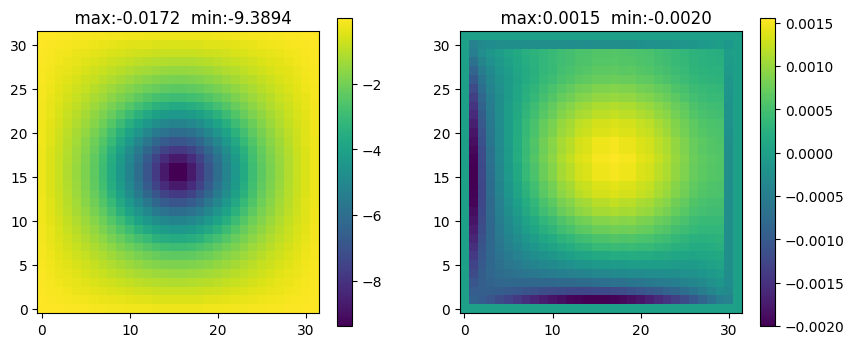

In [297]:
n=32
u = BonnorEbert(n=n,rc=0.1, r0=0.5)                    # Compute the density distribution
M = MultigridW(u,maxit=1000,itsmooth=3,tolerance=1e-3)  # Setup the Multigrid solver object

start = time()              # for timing
Phi, res, er = M.full_solve(u)  # call the multigrid solver
used = time() - start       # for timing

# print some statistics
ntot = u.n[0]*u.n[1]*u.n[2]
print("Nr of iterations, error, tolerance : {} {:.2e} {:.1e}".format(M.it, M.error, M.tolerance))
print("Time = {:.1f} seconds, {:.1f} musec/cell, {:.1f} nanosec/cell/it".format(
    used,1e6*used/ntot,1e9*used/(ntot*nt)))

# show potetial and residual
im.imshows(np.array([Phi[:,:,u.n[2]//2],res[:,:,u.n[2]//2]]))

MG level, n: 0 [64 64 64]
MG level, n: 1 [32 32 32]
MG level, n: 2 [16 16 16]
MG level, n: 3 [8 8 8]
MG level, n: 4 [4 4 4]
MG level, n: 5 [2 2 2]
Nr of iterations, error, tolerance : 19 9.88e-04 1.0e-03
Time = 1.8 seconds, 7.0 musec/cell, 7.1 nanosec/cell/it


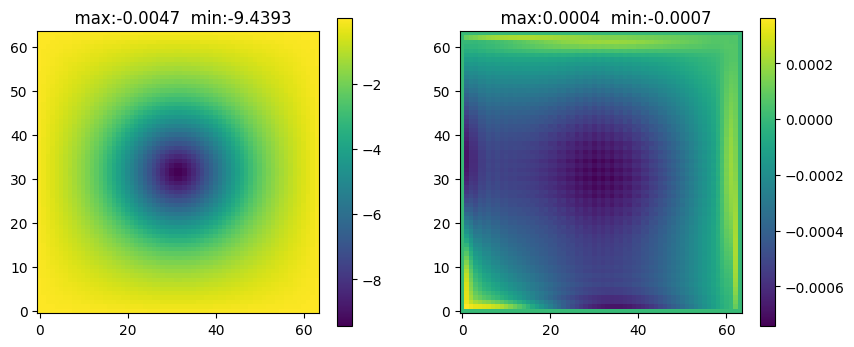

In [293]:
n=64
u = BonnorEbert(n=n,rc=0.1, r0=0.5)                    # Compute the density distribution
M = MultigridW(u,maxit=1000,itsmooth=3,tolerance=1e-3)  # Setup the Multigrid solver object

start = time()              # for timing
Phi, res, er = M.full_solve(u)  # call the multigrid solver
used = time() - start       # for timing

# print some statistics
ntot = u.n[0]*u.n[1]*u.n[2]
print("Nr of iterations, error, tolerance : {} {:.2e} {:.1e}".format(M.it, M.error, M.tolerance))
print("Time = {:.1f} seconds, {:.1f} musec/cell, {:.1f} nanosec/cell/it".format(
    used,1e6*used/ntot,1e9*used/(ntot*nt)))

# show potetial and residual
im.imshows(np.array([Phi[:,:,u.n[2]//2],res[:,:,u.n[2]//2]]))

MG level, n: 0 [128 128 128]
MG level, n: 1 [64 64 64]
MG level, n: 2 [32 32 32]
MG level, n: 3 [16 16 16]
MG level, n: 4 [8 8 8]
MG level, n: 5 [4 4 4]
MG level, n: 6 [2 2 2]
Nr of iterations, error, tolerance : 205 9.61e-04 1.0e-03
Time = 168.3 seconds, 80.3 musec/cell, 80.9 nanosec/cell/it


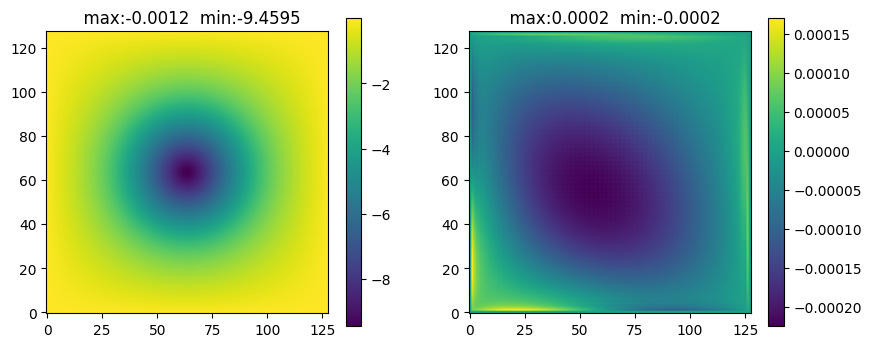

In [280]:
n=128
u = BonnorEbert(n=n,rc=0.1, r0=0.5)                    # Compute the density distribution
M = MultigridW(u,maxit=1000,itsmooth=3,tolerance=1e-3)  # Setup the Multigrid solver object

start = time()              # for timing
Phi, res, er = M.full_solve(u)  # call the multigrid solver
used = time() - start       # for timing

# print some statistics
ntot = u.n[0]*u.n[1]*u.n[2]
print("Nr of iterations, error, tolerance : {} {:.2e} {:.1e}".format(M.it, M.error, M.tolerance))
print("Time = {:.1f} seconds, {:.1f} musec/cell, {:.1f} nanosec/cell/it".format(
    used,1e6*used/ntot,1e9*used/(ntot*nt)))

# show potetial and residual
im.imshows(np.array([Phi[:,:,u.n[2]//2],res[:,:,u.n[2]//2]]))

Obviously, the W-Cycle uses less iterations in comparison to V-Cycle and the simple Jacobian method. This statement could be verified from the above runs for different resolutions. In general, we could recall that the coarse grid sweeps are much faster than the fine grid sweeps. Thus, we are expecting the W-cycle method, that stays on the coarse level longer, to be better than the V one for higher resolutions (below diagram).

In [306]:
wt=[]
for i in range(3,7,1):
    n=i
    u = BonnorEbert(n=2**i,rc=0.1, r0=0.5)                    # Compute the density distribution
    M = MultigridW(u,maxit=1000,itsmooth=3,tolerance=1e-3)  # Setup the Multigrid solver object

    start = time()              # for timing
    Phi, res, er = M.full_solve(u)  # call the multigrid solver
    used = time() - start       # for timing
    ntot = u.n[0]*u.n[1]*u.n[2]
    #print("Time = {:.1f} seconds, {:.1f} musec/cell, {:.1f} nanosec/cell/it".format(
    #used,1e6*used/ntot,1e9*used/(ntot*nt)))
    #print('\n')
    wt.append(used) 

MG level, n: 0 [8 8 8]
MG level, n: 1 [4 4 4]
MG level, n: 2 [2 2 2]
MG level, n: 0 [16 16 16]
MG level, n: 1 [8 8 8]
MG level, n: 2 [4 4 4]
MG level, n: 3 [2 2 2]
MG level, n: 0 [32 32 32]
MG level, n: 1 [16 16 16]
MG level, n: 2 [8 8 8]
MG level, n: 3 [4 4 4]
MG level, n: 4 [2 2 2]
MG level, n: 0 [64 64 64]
MG level, n: 1 [32 32 32]
MG level, n: 2 [16 16 16]
MG level, n: 3 [8 8 8]
MG level, n: 4 [4 4 4]
MG level, n: 5 [2 2 2]


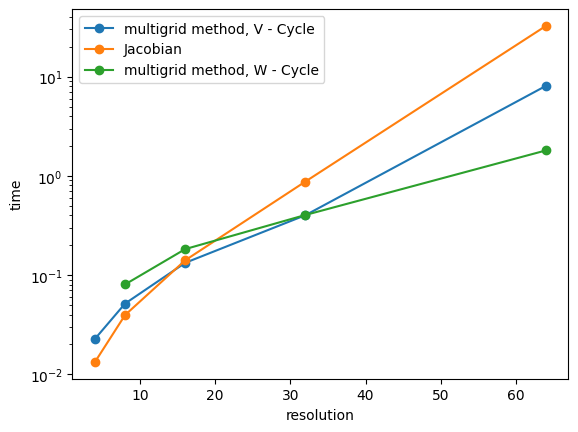

In [310]:
n=[2**i for i in range(2,7)]
nw=[2**i for i in range(3,7)]
plt.yscale("log")
plt.plot(n,mt,label='multigrid method, V - Cycle',marker='o')
plt.plot(n,jt,label='Jacobian',marker='o')
plt.plot(nw,wt,label='multigrid method, W - Cycle',marker='o')
plt.xlabel('resolution')
plt.ylabel('time')
plt.legend()